In [1]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import math
import random
import numpy as np
import os
import pandas as pd
from copy import copy
from Cindy_stimuli import *
from scipy.misc import imread
import pdb
import matplotlib.pyplot as plt
from lib.Cindy_utils import bb_iou_multi

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# a = PopoutGratings()
# a.create()

In [4]:
# b = PopoutCircles()
# b.create()

1

In [5]:
# python Cindy_demo.py --net res101 --dataset vg\
#                    --checksession 1 --checkepoch 20 --checkpoint 16193 \
#                    --cuda --stimuli gratings


In [6]:
conv1_feat = np.load('a.npy')

In [7]:
conv1_feat.shape

(1, 64, 150, 150)

In [8]:
single_item_width = 80 # hardcoding

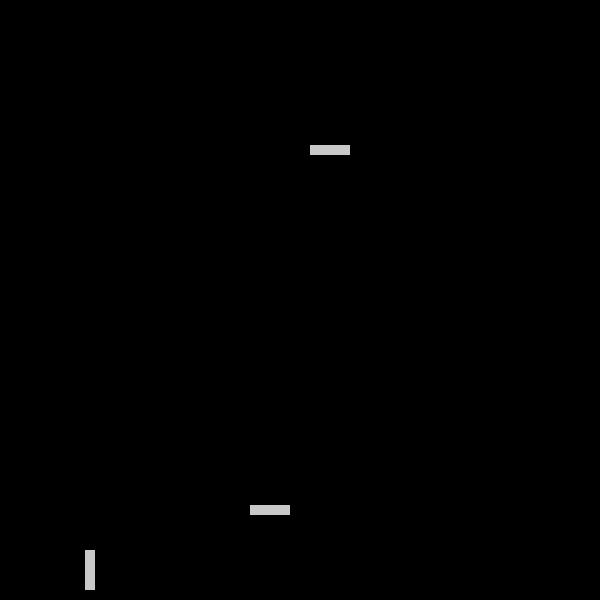

In [9]:
image = Image.open('images/gratings/0003.png')
image

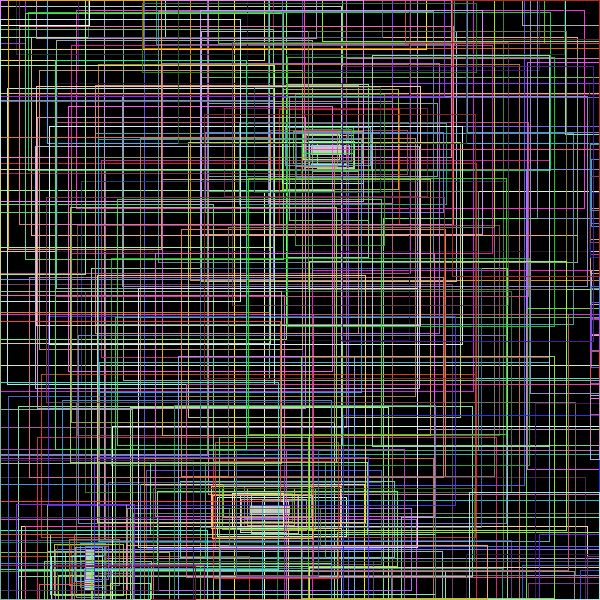

In [10]:
# my_rois = np.load('clutter_rois.npy') 
my_rois = np.load('my_rois.npy')
# my_rois = np.load('no_nms_rois.npy')
# my_rois = np.load('red_popout_rois.npy') 
# my_rois = np.load('red_popout_rois_1.npy')
# my_rois = np.load('grating_rois_1.npy')
# my_rois = np.load('popout_rois.npy') 
my_rois = my_rois[0,:,1:]
# first column of my_rois is all zero
# image = Image.new("RGB", (600, 800))
# image = Image.open('/om/user/xf15/NN/project/test_popout_green_circles_on_grid/cat09image0000.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles_on_grid/cat09image0001.png')
# image = Image.open('/om/user/xf15/NN/project/test_colorful_circles/cat10image0000.png')
num_box = my_rois.shape[0] #300
num_candiate_box = 300 # hardcoding
min_rgb = 20
max_rgb = 256
rs = (np.array(random.sample(range(min_rgb*10, max_rgb*10), num_box))/10).astype(int)
gs = (np.array(random.sample(range(min_rgb*10, max_rgb*10), num_box))/10).astype(int)
bs = (np.array(random.sample(range(min_rgb*10, max_rgb*10), num_box))/10).astype(int)


# gs = np.repeat(0, num_box)
# bs = np.repeat(0, num_box)
image0 = copy(image)
draw0 = ImageDraw.Draw(image0)
# (100)
# (100,200)
# (200,num_box)
# (10)
for iB in range(num_candiate_box):
# for iB in range(num_box):
#     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
    draw0.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image1.show()
# image1.save('temp.png')
image0

68


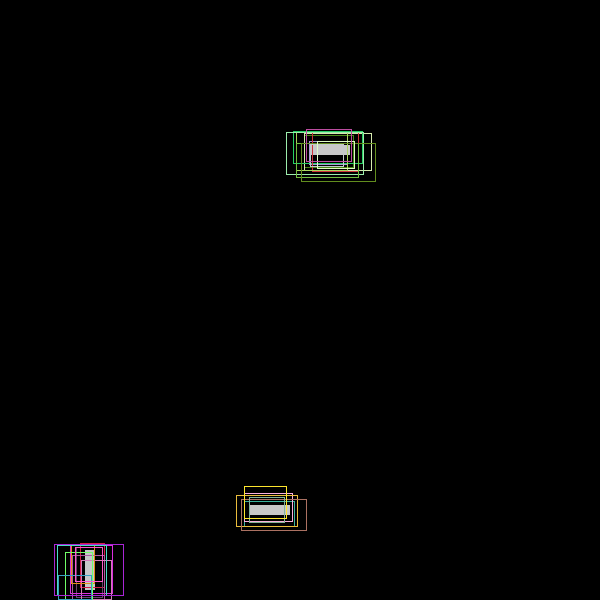

In [11]:
small_rois = np.ndarray((1,4), dtype="float32")
for iB in range(num_candiate_box):
    if my_rois[iB, 2] - my_rois[iB, 0] < single_item_width and my_rois[iB, 3] - my_rois[iB, 1] < 80:
#         print(iB)
        small_rois = np.vstack((small_rois, my_rois[iB, :]))
# small_rois = small_rois[1:,:]        
num_small_rois = small_rois.shape[0] # 68
print(num_small_rois)

# rs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
# gs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
# bs = np.array(random.sample(range(min_rgb, max_rgb), num_small_rois))
# print(my_rois.shape)
# print(small_rois.shape)
# image0 = copy(image)
# draw0 = ImageDraw.Draw(image0)
# # (100)
# # (100,200)
# # (200,num_box)
# # (10)
# for iB in range(50):
# # for iB in range(num_small_rois-1):
# #     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
#     draw0.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# # image1.show()
# # image1.save('temp.png')
# image0
image1 = copy(image)
draw1 = ImageDraw.Draw(image1)
# for iB in range(num_small_rois):
for iB in range(30):
    draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
#     draw1.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image1.show()
# image1.save('temp.png')
image1
# image2 = copy(image)
# draw2 = ImageDraw.Draw(image2)
# # for iB in range(num_small_rois-1):
# # for iB in d:
# for iB in list(set(range(num_small_rois-1)) - set(d)):
#     draw2.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# # image2.show()
# # image2.save('temp.png')
# image2

[[ 67.75632   554.54803   106.05387   593.92896  ]
 [302.7713    135.79897   354.66272   167.96422  ]
 [590.89923   270.88177   599.        335.71515  ]
 [243.2657    494.51645   292.56525   526.5133   ]
 [551.6127    562.14685   599.        599.       ]
 [  0.          0.         12.6833515  21.983116 ]
 [522.2703      0.        599.         25.607647 ]]


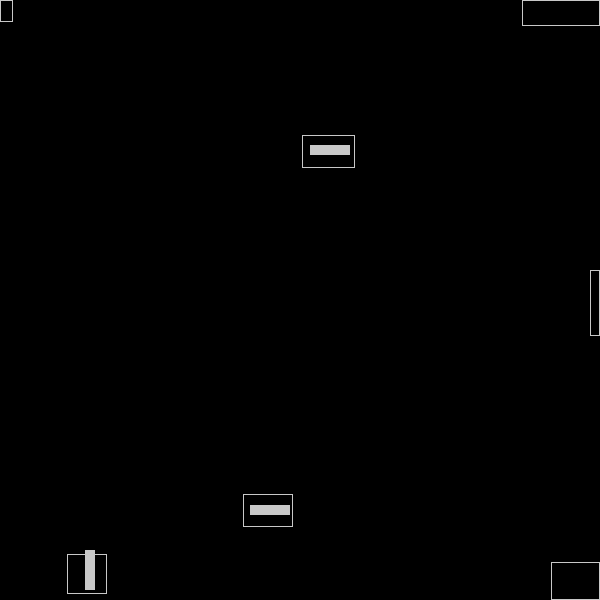

In [12]:
from sklearn.cluster import MeanShift
small_rois_centers = (small_rois[:, 0:2] + small_rois[:, 2:4])/2
clustering = MeanShift(bandwidth=single_item_width).fit(small_rois_centers)
num_clusters = len(set(clustering.labels_))
mean_clusterred_rois = np.zeros((num_clusters, 4), dtype = "float32")
for iC in range(num_clusters):
    mean_clusterred_rois[iC] = np.mean(small_rois[np.where(clustering.labels_ == iC)[0], :], axis=0)
print(mean_clusterred_rois)
image3 = copy(image)
draw3 = ImageDraw.Draw(image3)
for iB in mean_clusterred_rois:
#     print(iB)
    draw3.rectangle(iB, outline = (200,200,200))
image3

In [13]:
mean_clusterred_rois = np.concatenate((np.zeros((1, num_clusters)).T, mean_clusterred_rois), axis=1)
mean_clusterred_rois

array([[  0.        ,  67.75631714, 554.54803467, 106.05387115,
        593.92895508],
       [  0.        , 302.77130127, 135.79896545, 354.66271973,
        167.96421814],
       [  0.        , 590.89923096, 270.8817749 , 599.        ,
        335.71514893],
       [  0.        , 243.26570129, 494.51644897, 292.56524658,
        526.51330566],
       [  0.        , 551.6126709 , 562.14685059, 599.        ,
        599.        ],
       [  0.        ,   0.        ,   0.        ,  12.68335152,
         21.98311615],
       [  0.        , 522.27032471,   0.        , 599.        ,
         25.60764694]])

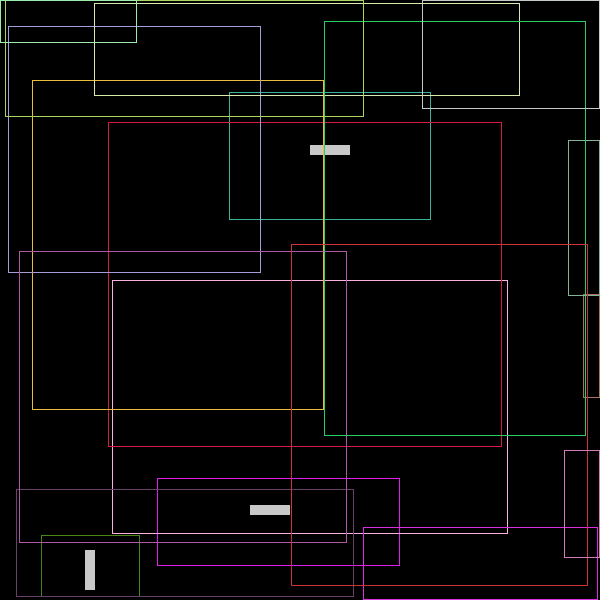

In [14]:
from sklearn.cluster import MeanShift
my_rois_centers = (my_rois[:, 0:2] + my_rois[:, 2:4])/2
clustering = MeanShift(bandwidth=single_item_width).fit(my_rois_centers)
num_clusters = len(set(clustering.labels_))
mean_clusterred_rois = np.zeros((num_clusters, 4), dtype = "float32")
for iC in range(num_clusters):
    mean_clusterred_rois[iC] = np.mean(my_rois[np.where(clustering.labels_ == iC)[0], :], axis=0)
# print(mean_clusterred_rois)
image4 = copy(image)
draw4 = ImageDraw.Draw(image4)
rois_ind = 0
for iB in mean_clusterred_rois:
#     print(iB)
    draw4.rectangle(iB, outline = (rs[rois_ind], gs[rois_ind], bs[rois_ind]))
    rois_ind += 1
image4

In [15]:
# from sklearn.cluster import MeanShift
# my_rois_centers = (rois_homo_to_hetro[:50, 0:2] + rois_homo_to_hetro[:50, 2:4])/2
# clustering = MeanShift(bandwidth=single_item_width).fit(my_rois_centers)
# num_clusters = len(set(clustering.labels_))
# mean_clusterred_rois = np.zeros((num_clusters, 4), dtype = "float32")
# for iC in range(num_clusters):
#     mean_clusterred_rois[iC] = np.mean(my_rois[np.where(clustering.labels_ == iC)[0], :], axis=0)
# # print(mean_clusterred_rois)
# image4 = copy(image)
# draw4 = ImageDraw.Draw(image4)
# rois_ind = 0
# for iB in mean_clusterred_rois:
# #     print(iB)
#     draw4.rectangle(iB, outline = (rs[rois_ind], gs[rois_ind], bs[rois_ind]))
#     rois_ind += 1
# image4

In [16]:
# aborted, must use nms with threshold 0.7, 
# my_prob = np.load('my_prob.npy')
# my_bbox = np.load('my_bbox.npy')
# rois_prob_order = np.argsort(my_prob)
# print(rois_prob_order_order)
# print(my_prob.shape)
# print(my_bbox.shape)
# np.mean(my_prob)
# rois_prob_order = np.argsort(my_prob)
# num_to_plot = 100
# image4 = copy(image)
# draw4 = ImageDraw.Draw(image4)
# # draw4.rectangle(np.float32(popout_rois), outline = (200,200,200))
# num_to_plot = 10
# for iB in range(num_to_plot):
# #     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
#     draw4.rectangle(my_rois[rois_sim_order[iB], :], outline = (rs[iB], gs[iB], bs[iB]))
# image4
# # my_bbox

In [18]:
def find_the_popout(X):
    X = mean_clusterred_rois
    num_items = X.shape[0]
    dists_matrix  = (np.sum(X**2, axis = 1) - 2 * X.dot(X.T)).T + np.sum(X**2, axis = 1)
    sum_dists_from_others = dists_matrix.sum(axis =0)
    popout_index = np.argmax(sum_dists_from_others)
    popout_rois = mean_clusterred_rois[popout_index, 1:5]
    return popout_rois
# import torch
# def find_the_popout(X):
#     X = torch.from_numpy(mean_clusterred_rois)
#     num_items = X.shape[0]
# #     dists_matrix  = (torch.sum(X**2, dim= 1) - 2 * X.mm(X.t())).t() + torch.sum(X**2, dim= 1)
#     dists_matrix  = (torch.sum(X**2, dim= 1) - 2 * torch.mm(X, X.t())).t() + torch.sum(X**2, dim= 1)
#     sum_dists_from_others = torch.sum(dists_matrix, dim =0)
#     popout_index = torch.max(sum_dists_from_others)
#     popout_rois = mean_clusterred_rois[popout_index, 1:5]
#     return popout_rois

In [19]:
# # c = b.sum(axis = 0)
# # d = np.where(c < 2)[0] 
# # # d = np.where(c < np.mean(c) - 2 * np.std(c))[0] # use mean and std

# # # print(b.shape)
# # # print(c.shape)
# # # print(d.shape)

# # print(np.mean(c))
# # print(np.std(c))

# # # import matplotlib.pyplot as plt
# # # plt.imshow(b);
# # # plt.colorbar()
# # # plt.show()
# # num_box
# # my_rois.shape
# # print(b.shape)
# # print(c.shape)
# # print(d.shape)
# image7 = copy(image)
# draw7 = ImageDraw.Draw(image7)
# a = bb_iou_multi(my_rois, my_rois)
# a.shape
# b = a>0.5
# bb = b.astype(np.float32)
# plt.imshow(bb)
# plt.colorbar()
# plt.show()
# b.shape
# c = bb_iou_multi(small_rois, small_rois)

# plt.imshow(c)
# plt.colorbar()
# plt.show()
# d = dists_matrix<400
# dd = d.astype(np.float32)
# e = b & d
# ee = e.astype(np.float32)
# plt.imshow(dd)
# plt.colorbar()
# plt.show()
# plt.imshow(ee)
# plt.colorbar()
# plt.show()
# ddd = np.where(dd.sum(axis = 0)>2)[0]
# for iB in eee:
# #     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
#     draw7.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image7

In [63]:
# my_feat = np.load('my_feat.npy')
# my_feat = np.load('my_conv1_feat.npy')
# my_feat = np.load('my_conv1_feat_before_melt.npy')
# my_feat = np.load('my_conv2_feat_before_melt.npy')
# my_feat = np.load('my_conv2_feat_before_melt.npy')
# my_feat = np.load('my_conv2_feat_before_melt.npy')
my_feat = np.load('my_conv4_feat_before_melt.npy')


# popout_rois = find_the_popout(my_feat)

In [64]:
# def contains_another_area():
boxes1 = my_rois
boxes2 = my_rois
x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
xA = np.maximum(x11, np.transpose(x21))
yA = np.maximum(y11, np.transpose(y21))
xB = np.minimum(x12, np.transpose(x22))
yB = np.minimum(y12, np.transpose(y22))
overlap = np.stack((xA, yA, xB, yB), axis = 2)
isbox1 = np.all(overlap == np.swapaxes(np.repeat(boxes1[:, :, np.newaxis], 300, axis = 2),1,2), axis = 2)
# isbox2 = np.all(overlap == np.swapaxes(np.swapaxes(np.repeat(boxes1[:, :, np.newaxis], 300, axis = 2),1,2),0,1), axis = 2)
# isanybox = np.logical_or(isbox1, isbox2) 
contains_any_other_box = np.sum(isbox1, axis=0) > 1



In [65]:
# rois_feat_std = np.std(my_feat, axis=1)
rois_feat_std = np.sum(np.std(my_feat, axis=(2, 3)), axis=1)
rois_homo_order = np.argsort(rois_feat_std)
rois_homo_order_reverse = np.argsort(rois_feat_std * (-1))
rois_homo_to_hetro = my_rois[rois_homo_order, :]
# top_k_hetro_rois_ind = 
image5 = copy(image)
draw5 = ImageDraw.Draw(image5)
# draw4.rectangle(np.float32(popout_rois), outline = (200,200,200))
num_to_plot = 50
for iB in range(num_to_plot):
#     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
#     draw5.rectangle(rois_homo_to_hetro[-iB, :], outline = (rs[iB], gs[iB], bs[iB]))
    draw5.rectangle(rois_homo_to_hetro[-iB, :], outline = (rs[iB], gs[iB], bs[iB]))
# image5

In [66]:
# try filter with feature similiarity with others
X = np.reshape(my_feat, (my_feat.shape[0], -1))
num_items = X.shape[0]
dists_matrix  = (np.sum(X**2, axis = 1) - 2 * X.dot(X.T)).T + np.sum(X**2, axis = 1)
sum_dists_from_others = dists_matrix.sum(axis =0)
rois_sim_order = np.argsort(sum_dists_from_others)
image4 = copy(image)
draw4 = ImageDraw.Draw(image4)
# draw4.rectangle(np.float32(popout_rois), outline = (200,200,200))
num_to_plot = 50
for iB in range(num_to_plot):
#     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
    draw4.rectangle(my_rois[rois_sim_order[iB], :], outline = (rs[iB], gs[iB], bs[iB]))
# image4

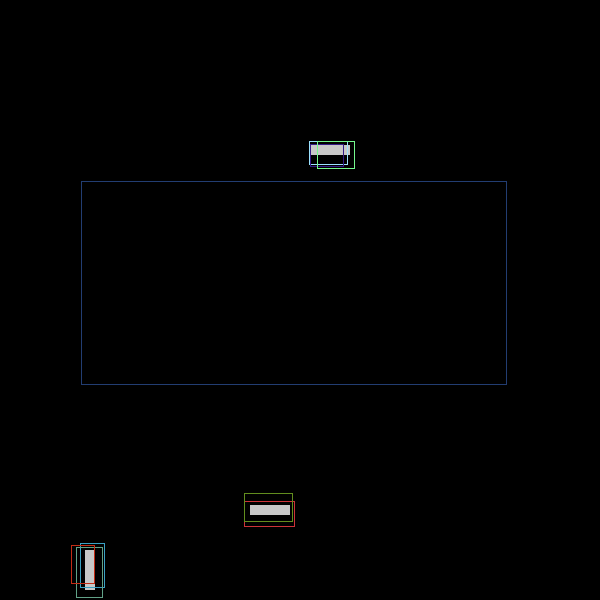

In [75]:
rois_hetro_simi = (rois_homo_order_reverse <200) &(rois_sim_order < 200) #& 
image8 = copy(image)
draw8 = ImageDraw.Draw(image8)
# draw4.rectangle(np.float32(popout_rois), outline = (200,200,200))
num_to_consider = 100#300#
small_rois = np.ndarray((1,4), dtype="float32")

for iB in range(num_to_consider):
    if rois_hetro_simi[iB]:
        if (not contains_any_other_box[iB]):
# #     draw1.rectangle(small_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
            draw8.rectangle(my_rois[iB, :], outline = (rs[iB], gs[iB], bs[iB]))
            small_rois = np.vstack((small_rois, my_rois[iB, :]))

small_rois = np.ndarray((1,4), dtype="float32")
      
        
        
largest_width = np.amax(small_rois[:,2] - small_rois[:, 0])
largest_height = np.amax(small_rois[:,3] - small_rois[:, 1])
single_item_width = np.maximum(largest_width, largest_height)
image8

In [73]:
my_rois.shape

(300, 4)

In [37]:
popout_index = np.argmax(sum_dists_from_others)
popout_rois = X[popout_index, 1:5]

In [57]:
small_rois


array([[564.3363  , 450.0222  , 599.      , 557.19836 ],
       [244.36366 , 493.49704 , 292.2232  , 521.17676 ],
       [ 76.69136 , 547.66077 , 102.117935, 597.5847  ],
       [ 72.95816 , 555.3767  , 104.18001 , 599.      ],
       [310.54715 , 144.63206 , 343.53452 , 166.5414  ],
       [ 65.05571 , 552.9576  ,  92.85176 , 599.      ]], dtype=float32)

In [39]:
a =find_the_popout(mean_clusterred_rois)

In [40]:
my_feat.shape

(300, 1024, 8, 8)

In [41]:
small_rois[iB, :]

IndexError: index 99 is out of bounds for axis 0 with size 68

In [ ]:
feat_df = pd.DataFrame(my_feat.T, index = range(2048))
plt.figure() 
feat_df.plot(alpha=0.5)
plt.show()

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))
df = df.cumsum()

In [ ]:
plt.figure() 
df.plot()
plt.show()

In [ ]:
rois_sim_order


In [ ]:
isanybox

In [ ]:
isbox1

In [ ]:
contains_any_other_box


In [ ]:
np.swapaxes(np.repeat(boxes1[:, :, np.newaxis], 300, axis = 2),1,2)

In [ ]:
np.swapaxes(np.repeat(boxes1[:, :, np.newaxis], 300, axis = 2),1,2).T